In [1]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')

           date  Passengers
0    31/01/1949         112
1    28/02/1949         118
2    31/03/1949         132
3    30/04/1949         129
4    31/05/1949         121
..          ...         ...
139  31/08/1960         606
140  30/09/1960         508
141  31/10/1960         461
142  30/11/1960         390
143  31/12/1960         432

[144 rows x 2 columns]


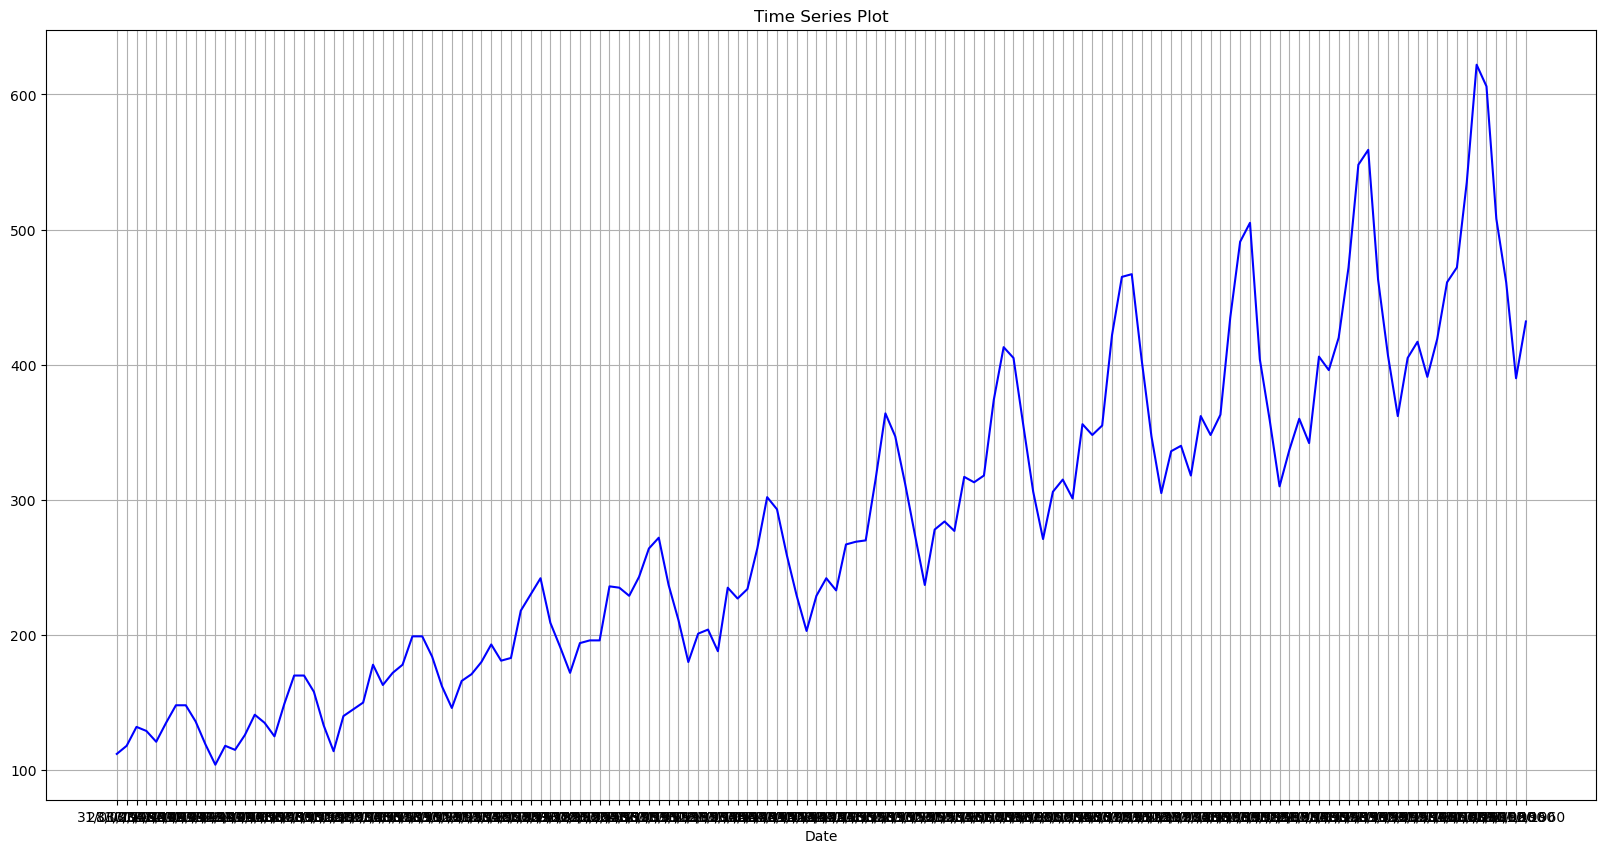

In [6]:
df = pd.read_csv('air-passengers.csv')

print(df)

df.set_index('date', inplace=True)

plt.figure(figsize=(20, 10))
plt.plot(df, linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.grid(True)
plt.show()